In [1]:
%reload_ext tgpy
import tgpy as tg

# Data

In [2]:
df = tg.pd.read_pickle('../../../Datos/tierras_raras.pkl')
filtro = df.Region == 'ANTOFAGASTA'
#filtro = df.Region == 'VALPARAISO'


inputs = ['Coord. N', 'Coord. E']
outputs = ['Pr(g/t)']
#outputs = ['Y(g/t)']
#outputs = ['Nd(g/t)']
#outputs = ['Dy(g/t)']
#outputs = ['Yb(g/t)']

dt = tg.DataTensor(df[filtro][inputs + outputs], inputs=inputs, outputs=outputs)
n = dt.ndata
dt

,Coord. N,Coord. E,Pr(g/t)
7,7190193.0,351515.0,50.02
15,7190110.0,351456.0,26.13
31,7160725.0,340194.0,8.55
33,7407014.0,393185.0,10.59
47,7327033.0,495795.0,8.96
...,...,...,...
2020,7308091.0,493083.0,0.43
2023,7188809.0,349758.0,0.41
2026,7308106.0,493100.0,0.42
2030,7222378.0,444925.0,0.33


In [3]:
df.groupby('Region').count()['IDQ']

Region
ANTOFAGASTA        92
ATACAMA           457
AYSEN              31
COQUIMBO         1118
MAULE               3
METROPOLITANA      66
OHIGGINS           33
TARAPACA           10
VALPARAISO        222
Name: IDQ, dtype: int64

In [4]:
dt.scale_inputs *= 0
dt.scale_inputs += 1000
#dt.shift_outputs *= 0
#dt.scale_outputs = 0 * dt.scale_outputs + 1

# Priors

In [5]:
dim = 100

In [6]:
high = 0.5
var_rq = tg.TgPrior('var_rq', ['o'], dim=dim, low=0, high=high, alpha=2, beta=4)
var_se = tg.TgPrior('var_se', ['o'], dim=dim, low=0, high=high, alpha=2, beta=4)
var_ou = tg.TgPrior('var_ou', ['o'], dim=dim, low=0, high=high, alpha=2, beta=4)
var_sinc = tg.TgPrior('var_sinc', ['o'], dim=dim, low=0, high=high, alpha=2, beta=4)
#var()

/home/francisco/Dropbox/Tierras raras/Python/tgpy/tgpy/prior.py:165: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/francisco/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.norm_const = torch.lgamma(c.sum(-1)) - torch.lgamma(c).sum(-1) - self.scale.abs().log()


In [7]:
relevance = tg.TgPrior('relevance', ['x', 'y'], dim=dim, low=0.5, high=2, alpha=2, beta=4)
#relevance_se = tg.TgPrior('relevance_se', ['x', 'y'], dim=dim, low=0.5, high=2)
#relevance.p.x.data = relevance.p.x.data * 0.0 + 0.5
#relevance.p.y.data = relevance.p.y.data * 0.0 + 0.2
#relevance()

In [8]:
freedom = tg.TgPrior('freedom', ['o'], dim=dim, low=1, high=5, alpha=2, beta=4)
#freedom()

In [9]:
period = tg.TgPrior('period', ['x', 'y'], dim=dim, low=0.0, high=3, alpha=2, beta=4)

In [11]:
noise = tg.TgPrior('noise', ['o'], dim=dim, low=0.0, high=0.1, alpha=2, beta=4)
#noise()

In [10]:
shift = tg.TgPrior('shift', ['o'], dim=dim, low=-0.1, high=0, alpha=2, beta=4)
#shift()

In [12]:
power = tg.TgPrior('power', ['o'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
#power()

# Model

In [13]:
kernel = tg.RQ(var_rq, relevance, freedom) #+ tg.SINC(var_sinc, relevance, period) + tg.SE(var_se, relevance) + tg.OU(var_ou, relevance)
cov = tg.CovarianceTransport(kernel, noise=tg.WN(noise))

In [14]:
marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
positive = tg.MarginalTransport(tg.Relu())

In [15]:
tgp = tg.TGP([cov, marginal, positive], dt=dt)

# Cross-Validation

In [16]:
pobs = 0.8

nobs = int(pobs*n)
perm = tg.np.random.permutation(dt.index)
train = perm[:nobs]
valid = perm[nobs:]

train = dt.original_outputs(train).sort_values(by=dt.outputs).index.values
valid = dt.original_outputs(valid).sort_values(by=dt.outputs).index.values

# Learning

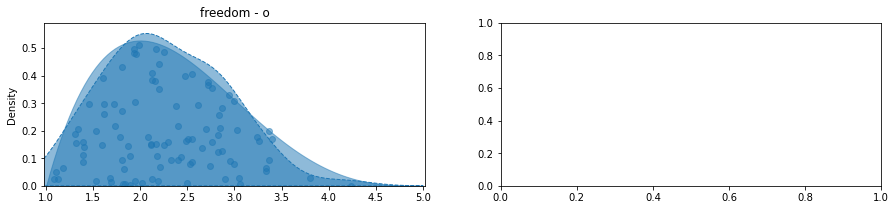

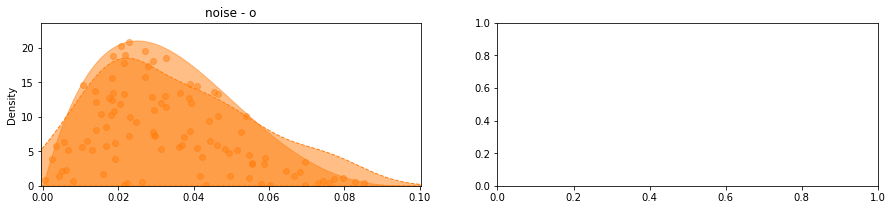

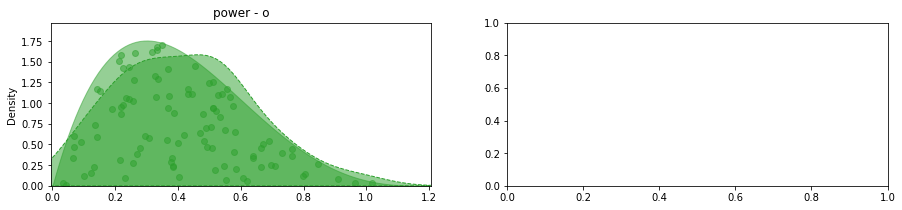

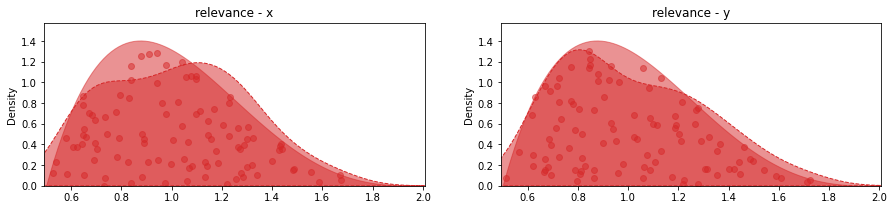

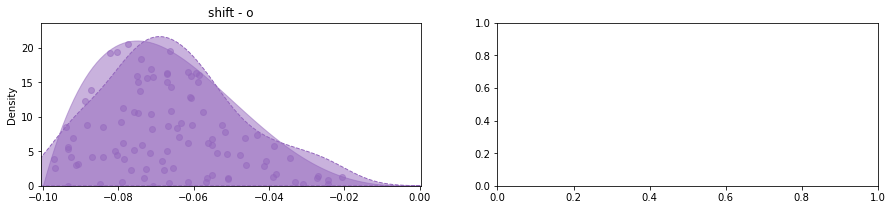

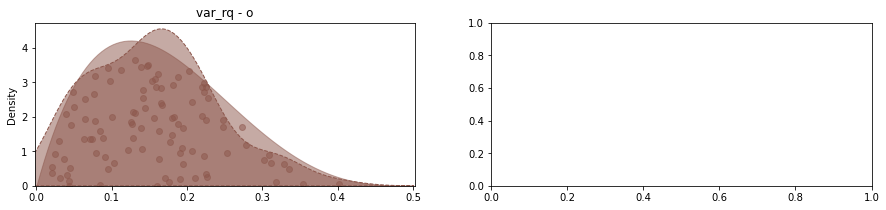

In [17]:
tgp.obs(index=train)
tgp.sample_priors()
tgp.plot_priors()

In [18]:
learning = tg.TgLearning(tgp, lr=0.001, pbatch=0.8, rand_pert=0.0, pot=0, cycle=0.1)
tgp.logp()

tensor([ -215.7105,   -43.7863,   -27.8599, -1542.0457,  -122.3001,   -22.9676,
          -45.4252,   -17.8963,   -22.1563,   -22.6819,   -26.9546,   -54.5717,
          -15.3304,   -19.2613,   -18.5492,  -172.4019,   -46.4256,   -59.5659,
         -211.4207,   -39.8208,   -17.3287,   -60.9192,   -14.4167,   -46.2139,
          -26.5846,  -103.0227,   -27.4507,   -94.0507,   -64.8807,   -45.1979,
          -13.8279,   -66.5416,   -19.9875,   -22.6144,  -176.7883,   -34.7516,
          -49.0034,   -88.2152,   -90.3168,   -29.5878,   -33.0549,   -16.9325,
          -63.0323,   -19.8654,   -80.2099,  -401.7667,   -99.7020,   -82.2232,
          -19.3639,   -18.5898,   -94.5634,  -321.4917,   -21.3306,   -17.2392,
          -20.3081,   -19.7993,   -27.5411,   -21.5019,  -104.1255,   -81.4761,
          -14.2209,   -21.1483,   -46.1495,   -29.4949,   -20.1747,   -15.7094,
          -14.7777,   -16.7183,   -71.6863,   -57.7064,   -15.1784,   -64.3522,
          -14.1458,   -26.0734,  -109.70

  0%|                                                                                                         …

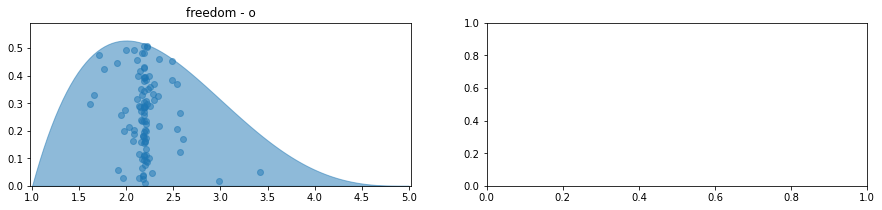

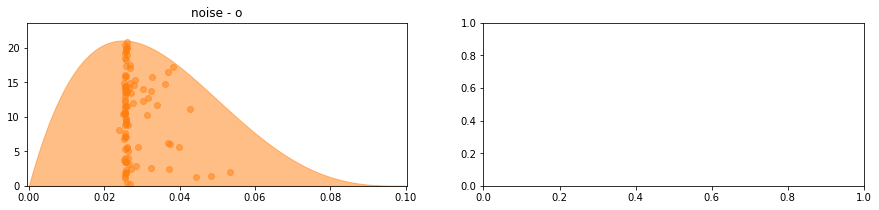

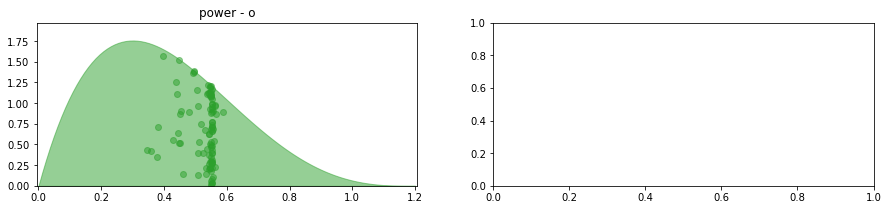

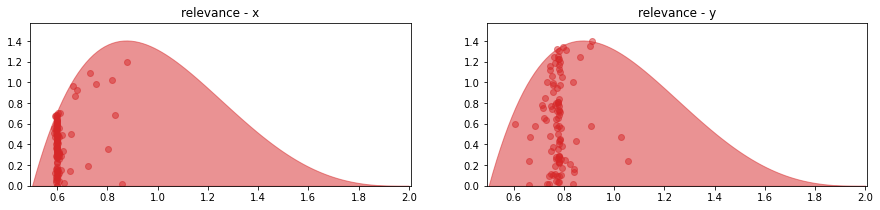

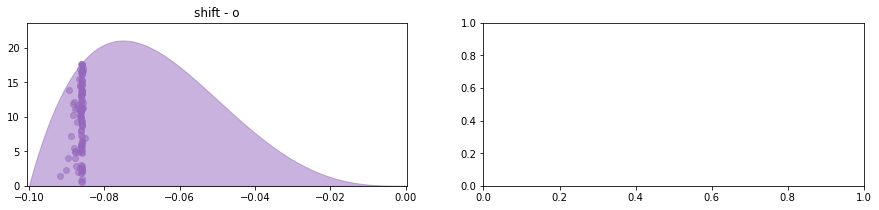

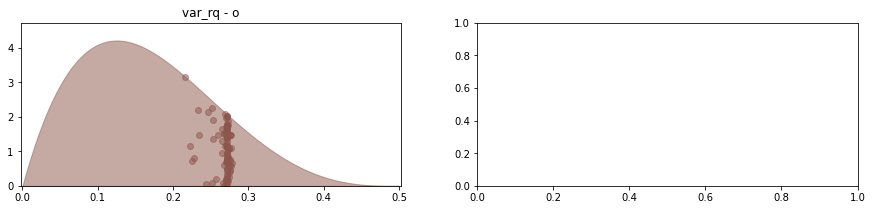

In [19]:
learning.execute_sgd(1000)
tgp.plot_priors(kde=False)

  0%|                                                                                                         …

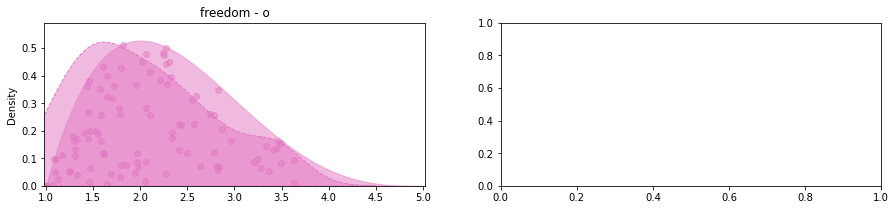

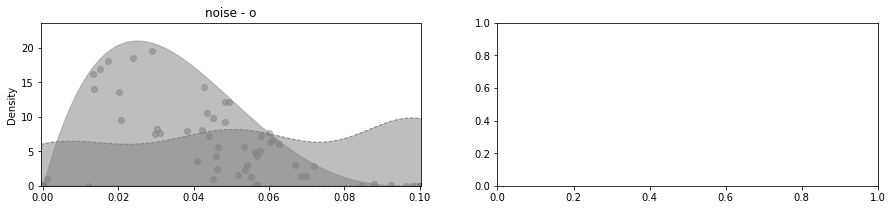

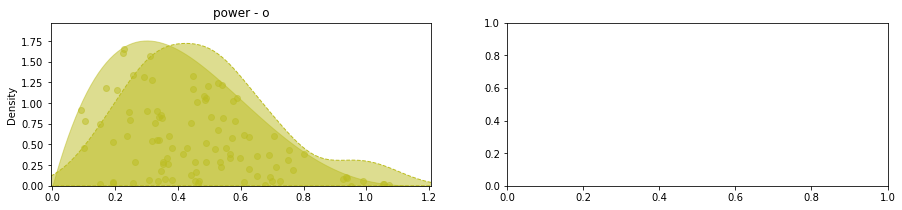

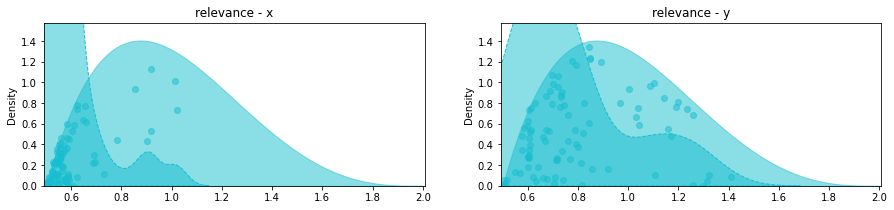

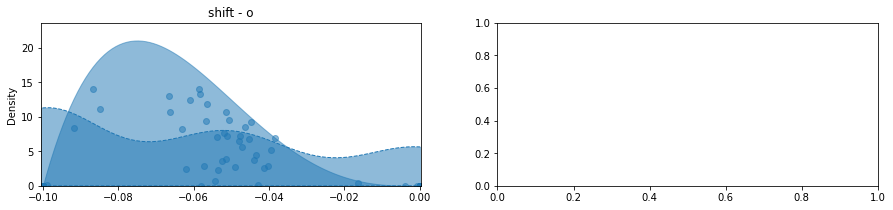

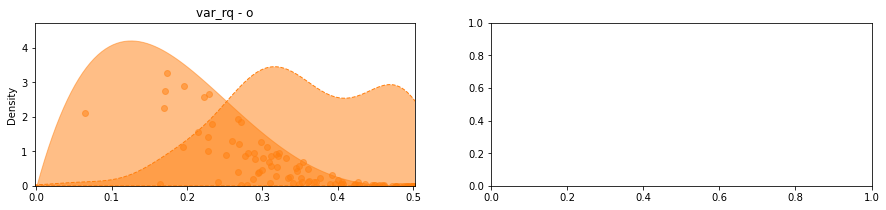

In [52]:
learning.execute_svgd(1000)
tgp.plot_priors(kde=True)

# Eval

In [20]:
dt.original_inputs(valid)

,Coord. N,Coord. E
2023,7188809.0,349758.0
1827,7308082.0,493103.0
1748,7222306.0,444856.0
1354,7189175.0,354192.0
1150,7222266.0,444719.0
1129,7188232.0,399288.0
1038,7188318.0,399179.0
685,7484589.0,367829.0
503,7222507.0,348643.0
561,7463263.0,464803.0


In [21]:
quantiles = 0.3
pred, samples = tgp.predict(dt.original_inputs(valid), quantiles=quantiles, nsamples=1000, samples=True, noise=True)
pred

,Coord. N,Coord. E,Median,Mean,Quantile 70,Quantile 30
2023,7188809.0,349758.0,2.394934,2.486615,2.890590,2.011532
1827,7308082.0,493103.0,1.099693,1.172327,1.440778,0.776415
1748,7222306.0,444856.0,1.727244,1.770615,2.096923,1.346941
1354,7189175.0,354192.0,3.797211,3.864355,4.381657,3.203983
1150,7222266.0,444719.0,2.485547,2.529321,2.939831,2.066098
1129,7188232.0,399288.0,3.455038,3.535867,4.016539,2.945634
1038,7188318.0,399179.0,3.287005,3.299482,3.751954,2.757570
685,7484589.0,367829.0,4.651998,4.844121,5.673271,3.669345
503,7222507.0,348643.0,4.335426,4.706160,5.813597,3.122939
561,7463263.0,464803.0,4.322367,4.356161,4.907132,3.675329


In [73]:
#to_eval = train
to_eval = valid

real = dt.original_outputs(to_eval)[dt.outputs[0]]

In [74]:
quantiles = 0.6 # 0.5 - 1.0
pred, samples = tgp.predict(to_eval, quantiles=quantiles, nsamples=1000, samples=True, noise=True)
pred

,Coord. N,Coord. E,Pr(g/t),Median,Median Error,Mean,Mean Error,Quantile 40,Quantile 60
1752,7188809.0,349733.0,1.83,1.562714,0.267286,1.713209,0.116791,1.285972,1.842825
1499,7222496.0,444638.0,2.44,2.490497,-0.050497,3.236461,-0.796461,2.095480,2.900334
1377,7222444.0,444656.0,2.78,2.418363,0.361637,2.727216,0.052784,2.138088,2.773539
1255,7222231.0,444725.0,2.96,2.577129,0.382871,2.616485,0.343515,2.302474,2.847311
1150,7222266.0,444719.0,3.24,2.497167,0.742833,2.505700,0.734300,2.292186,2.590337
1004,7463261.0,464804.0,3.80,4.880267,-1.080267,5.202749,-1.402749,4.534712,5.305178
685,7484589.0,367829.0,4.14,4.590673,-0.450673,5.010432,-0.870432,4.002471,5.254100
905,7189246.0,354093.0,4.15,3.946794,0.203206,4.466393,-0.316393,3.456994,4.513621
717,7466009.0,465702.0,4.15,5.065718,-0.915718,5.413809,-1.263809,4.708952,5.500979
561,7463263.0,464803.0,4.61,4.929303,-0.319303,5.207521,-0.597521,4.559614,5.319991


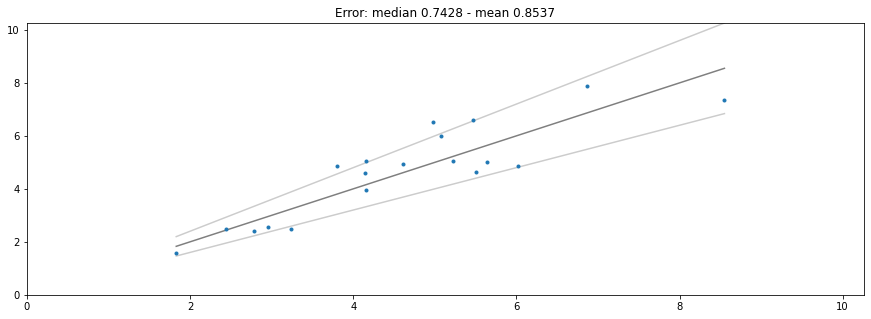

In [75]:
tg.plt.figure(figsize=(15,5))

tg.plot2d(real, real, color='k', alpha=0.5)
tg.plot2d(real, real * (1.2), color='k', alpha=0.2)
tg.plot2d(real, real * (0.8), color='k', alpha=0.2)

#tg.plot2d(dt.tensor_outputs[valid, 0], (pred.nanmean(dim=0) + pred.nanmedian(dim=0).values)/2, linestyle='None', marker='.')
#tg.plot2d(real, pred.mean(),linestyle='None', marker='.')
tg.plot2d(real, pred['Median'],linestyle='None', marker='.')

tg.plt.xlim([0,real.max()*1.2])
tg.plt.ylim([0,real.max()*1.2])
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

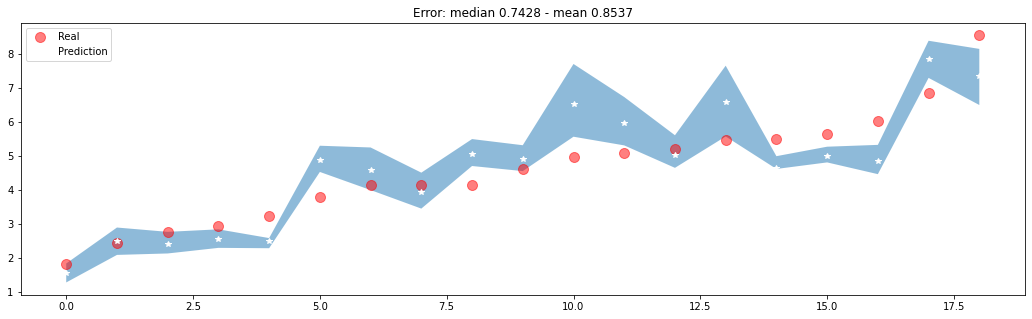

In [76]:
ax = tg.plt.subplots(figsize=(18,5))

tg.plot2d(real, color='r', alpha=0.5, linestyle='None', marker='.', ms=20, label='Real')
tg.plot2d(pred['Median'], linestyle='None', marker='*', color='white', label='Prediction')
#tg.plot2d(pred.mean(), linestyle='None', marker='*', color='k', label='Prediction')


tg.plt.fill_between(tg.np.arange(len(real)), pred['Quantile '+str(int(100*(1-quantiles)))], pred['Quantile '+str(int(100*quantiles))], alpha=0.5)

#tg.sb.violinplot(data=pred, inner='quartile', scale='count')
#tg.plt.ylim([0, real.max()+2])
tg.plt.legend()
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

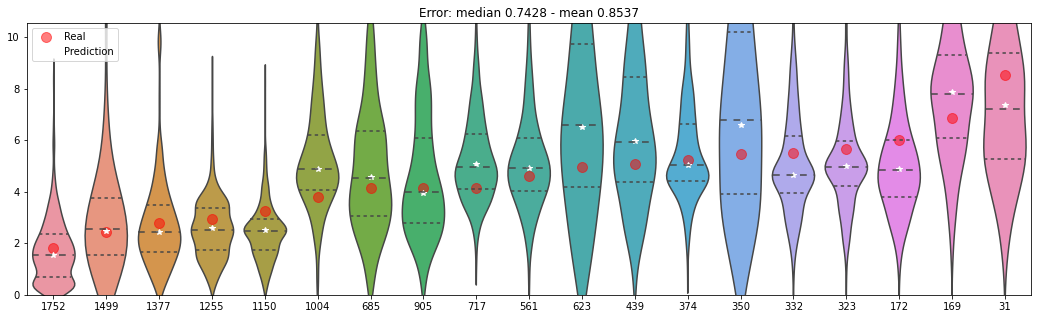

In [77]:
ax = tg.plt.subplots(figsize=(18,5))

tg.plot2d(real, color='r', alpha=0.5, linestyle='None', marker='.', ms=20, label='Real')
tg.plot2d(pred['Median'], linestyle='None', marker='*', color='white', label='Prediction')

tg.sb.violinplot(data=samples.sample(1000), inner='quartile', scale='count')
tg.plt.ylim([0, real.max()+2])
tg.plt.legend()
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

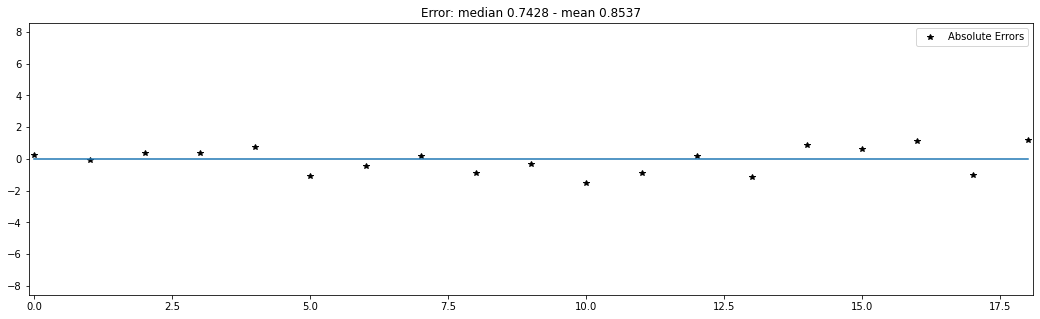

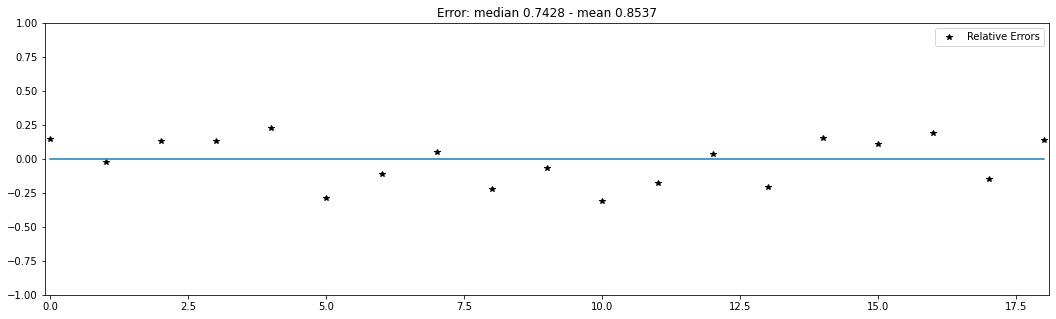

In [78]:
ax = tg.plt.subplots(figsize=(18,5))

tg.plot2d((pred['Median Error']), linestyle='None', marker='*', color='k', label='Absolute Errors')
tg.plot2d(0 * real)
tg.plt.legend()
tg.plt.xlim([-0.1, len(to_eval)-0.9])
tg.plt.ylim([-real.max(), real.max()])
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

ax = tg.plt.subplots(figsize=(18,5))
tg.plot2d(pred['Median Error']/real, linestyle='None', marker='*', color='k', label='Relative Errors')
tg.plot2d(0 * real)
tg.plt.legend()
tg.plt.xlim([-0.1, len(to_eval)-0.9])
tg.plt.ylim([-1, 1])
tg.plt.title('Error: median %.4f - mean %.4f' % (pred['Median Error'].abs().median(), pred['Mean Error'].abs().mean()));

In [22]:
pred

,Coord. N,Coord. E,Median,Mean,Quantile 70,Quantile 30
2023,7188809.0,349758.0,2.394934,2.486615,2.890590,2.011532
1827,7308082.0,493103.0,1.099693,1.172327,1.440778,0.776415
1748,7222306.0,444856.0,1.727244,1.770615,2.096923,1.346941
1354,7189175.0,354192.0,3.797211,3.864355,4.381657,3.203983
1150,7222266.0,444719.0,2.485547,2.529321,2.939831,2.066098
1129,7188232.0,399288.0,3.455038,3.535867,4.016539,2.945634
1038,7188318.0,399179.0,3.287005,3.299482,3.751954,2.757570
685,7484589.0,367829.0,4.651998,4.844121,5.673271,3.669345
503,7222507.0,348643.0,4.335426,4.706160,5.813597,3.122939
561,7463263.0,464803.0,4.322367,4.356161,4.907132,3.675329


In [23]:
dt

,Coord. N,Coord. E,Pr(g/t)
7,7190193.0,351515.0,50.02
15,7190110.0,351456.0,26.13
31,7160725.0,340194.0,8.55
33,7407014.0,393185.0,10.59
47,7327033.0,495795.0,8.96
...,...,...,...
2020,7308091.0,493083.0,0.43
2023,7188809.0,349758.0,0.41
2026,7308106.0,493100.0,0.42
2030,7222378.0,444925.0,0.33
